In [4]:
import collections

import hetmatpy
import hetmatpy.hetmat
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

%matplotlib inline

## 1. Download and process data

In [2]:
# High-throughput
rolland_df = pd.read_table('http://interactome.baderlab.org/data/Rolland-Vidal(Cell_2014).psi')

# Literature-curated
litbm_df = pd.read_table('http://interactome.baderlab.org/data/LitBM-17.psi', header=None)

In [3]:
rolland_edges_df = (
    rolland_df
    .rename(columns={"Unique identifier for interactor A": "id_a",
                    "Unique identifier for interactor B": "id_b"})
    .filter(items=['id_a', 'id_b'])
    .query('id_a != "-" and id_b != "-"')
)
rolland_edges = list(map(tuple, rolland_edges_df.values.tolist()))

litbm_edges_df = (
    litbm_df
    .rename(columns={0: 'id_a', 1: 'id_b'})
    .filter(items=['id_a', 'id_b'])
)
litbm_edges = list(map(tuple, litbm_edges_df.values.tolist()))

## 2. Degree distributions

In [4]:
ht_protein_to_degree = (
    collections.Counter(rolland_edges_df['id_a'])
    + collections.Counter(rolland_edges_df['id_b'])
)

lit_protein_to_degree = (
    collections.Counter(litbm_edges_df['id_a']) 
    + collections.Counter(litbm_edges_df['id_b'])
)

In [5]:
lit_degree_df = (pd.DataFrame
    .from_dict(lit_protein_to_degree, orient='index')
    .reset_index()
    .rename(columns={'index': 'protein', 0: 'degree'}))

ht_degree_df = (pd.DataFrame
    .from_dict(ht_protein_to_degree, orient='index')
    .reset_index()
    .rename(columns={'index': 'protein', 0: 'degree'}))

degree_type_df = ht_degree_df.merge(lit_degree_df, on='protein', how='outer', suffixes=('_ht', '_lit')).fillna(0)

degree_type_df.head(2)

,protein,degree_ht,degree_lit
0,uniprotkb:A0A0R4J2E4,120.0,0.0
1,uniprotkb:O60573-1,117.0,0.0


Text(0, 0.5, 'likelihood of occurrence')

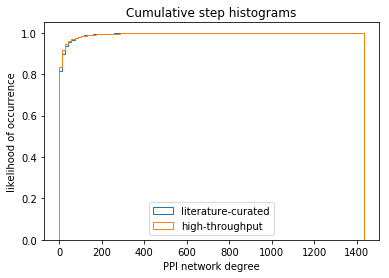

In [6]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(degree_type_df['degree_lit'], label='literature-curated', bins=100,
                           density=True, histtype='step', cumulative=True)
ax.hist(degree_type_df['degree_ht'], label='high-throughput',
        bins=bins, density=True, histtype='step', cumulative=True)

ax.legend(loc='lower center')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('PPI network degree')
ax.set_ylabel('likelihood of occurrence')

Text(0, 0.5, 'log likelihood of occurrence')

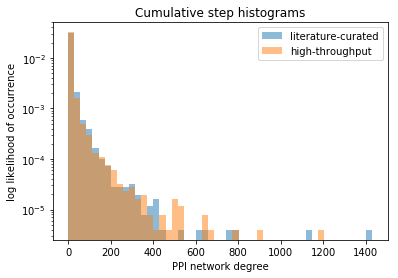

In [7]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(degree_type_df['degree_lit'], label='literature-curated', bins=50,
                           density=True, alpha=0.5, log=True)
ax.hist(degree_type_df['degree_ht'], label='high-throughput',
        bins=bins, density=True, alpha=0.5)

ax.legend(loc='best')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('PPI network degree')
ax.set_ylabel('log likelihood of occurrence')

In [24]:
scipy.stats.wilcoxon(degree_type_df['degree_ht'].values, degree_type_df['degree_lit'].values)

WilcoxonResult(statistic=17846874.0, pvalue=3.755148556265312e-09)

## 3. Neighborhood structure

In [9]:
ht_graph = nx.from_edgelist(rolland_edges)
lit_graph = nx.from_edgelist(litbm_edges)

In [10]:
nx.average_clustering(ht_graph)

0.042326842340628244

In [11]:
nx.average_clustering(lit_graph)

0.05437081660507099

In [32]:
feature_df = (pd.DataFrame
 .from_dict(nx.clustering(ht_graph), orient='index')
 .reset_index()
 .rename(columns={0: 'ht_clustering', 'index': 'node_id'})
 .assign(
     lit_degree=lambda x: x.node_id.map(nx.degree(lit_graph)),
     lit_clustering=lambda x: x.node_id.map(nx.clustering(lit_graph)),
     lit_centrality=lambda x: x.node_id.map(nx.degree_centrality(lit_graph)),
     ht_degree=lambda x: x.node_id.map(nx.degree(ht_graph)),
     ht_centrality=lambda x: x.node_id.map(nx.degree_centrality(ht_graph)),
 )
 .dropna()
)

int_cols = ['ht_degree', 'lit_degree']
float_cols = ['ht_clustering', 'lit_clustering', 'ht_centrality', 'lit_centrality']
feature_df[int_cols] = feature_df[int_cols].astype(int)
feature_df[float_cols] = feature_df[float_cols].astype(float)

In [33]:
feature_df.head()

,node_id,ht_clustering,lit_degree,lit_clustering,lit_centrality,ht_degree,ht_centrality
5,uniprotkb:P52292,0.019763,11,0.0,0.002213,23,0.005238
8,uniprotkb:Q12874,0.000000,1,0.0,0.000201,3,0.000683
28,uniprotkb:Q13526,0.020677,12,0.0,0.002414,57,0.012981
35,uniprotkb:O43639,0.021212,13,0.0,0.002616,47,0.010704
51,uniprotkb:Q96IK5,0.009740,4,0.0,0.000805,58,0.013209


In [34]:
scipy.stats.wilcoxon(feature_df['ht_clustering'], feature_df['lit_clustering'])

WilcoxonResult(statistic=13202.0, pvalue=0.7604115910253426)

(array([8.8172043 , 0.51971326, 0.16129032, 0.2688172 , 0.03584229,
        0.01792115, 0.03584229, 0.        , 0.        , 0.14336918]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

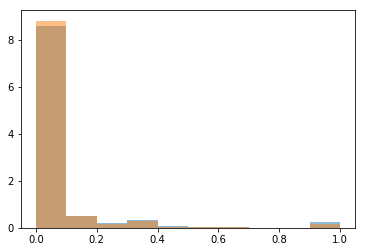

In [35]:
plt.hist(feature_df['lit_clustering'], alpha=0.5, density=True)
plt.hist(feature_df['ht_clustering'], alpha=0.5, density=True)

(array([525.10950662,  69.37665463,  21.53068592,  19.13838748,
          8.37304452,   4.78459687,   5.98074609,   1.19614922,
          4.78459687,   2.39229844]),
 array([0.00020121, 0.00171026, 0.00321932, 0.00472837, 0.00623742,
        0.00774648, 0.00925553, 0.01076459, 0.01227364, 0.0137827 ,
        0.01529175]),
 <a list of 10 Patch objects>)

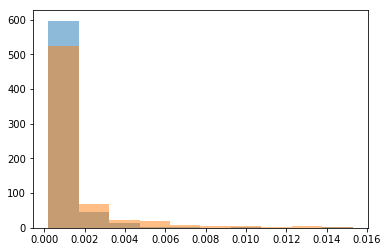

In [39]:
_, bins, _ = plt.hist(feature_df['lit_centrality'], alpha=0.5, density=True)
plt.hist(feature_df['ht_centrality'], alpha=0.5, density=True, bins=bins)

In [40]:
scipy.stats.wilcoxon(feature_df['ht_centrality'], feature_df['lit_centrality'])

WilcoxonResult(statistic=55994.0, pvalue=7.758148679861727e-09)

In [42]:
rolland_df.columns

Index(['Unique identifier for interactor A',
       'Unique identifier for interactor B',
       'Alternative identifier for interactor A',
       'Alternative identifier for interactor B', 'Aliases for A',
       'Aliases for B', 'Interaction detection methods', 'First author',
       'Identifier of the publication',
       'NCBI Taxonomy identifier for interactor A',
       'NCBI Taxonomy identifier for interactor B', 'Interaction types',
       'Source databases', 'Interaction identifier(s)', 'Confidence score',
       'Complex expansion', 'Biological role A', 'Biological role B',
       'Experimental role A', 'Experimental role B', 'Interactor type A',
       'Interactor type B', 'Xref for interactor A', 'Xref for interactor B',
       'Xref for the interaction', 'Annotations for interactor A',
       'Annotations for interactor B', 'Annotations for the interaction',
       'NCBI Taxonomy identifier for the host organism',
       'Parameters of the interaction', 'Creation date', 'U

## Degree distribution follows power law

### Erdős-Renyi random graph has Gaussian degree distribution

(0.99848872423172, 0.06885498762130737)

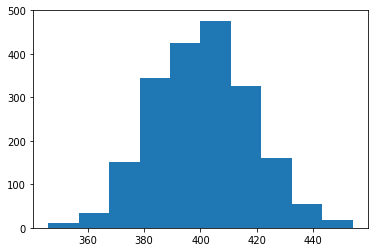

In [135]:
g = nx.erdos_renyi_graph(2000, 0.2, seed=1)

mat = nx.adjacency_matrix(g)

plt.hist(mat.sum(axis=1))

scipy.stats.shapiro(mat.sum(axis=1))

### Real bipartite graphs (like `CtD` relationship) have power law degree distributions

Text(0.5, 0, 'Disease degree')

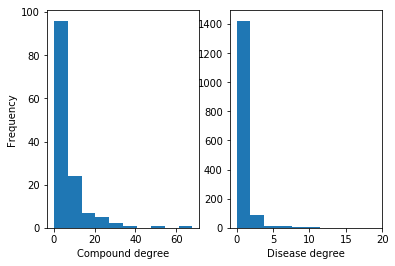

In [136]:
hetmat = hetmatpy.hetmat.HetMat('../../../hetmech/data/hetionet-v1.0.hetmat/')

_, _, mat = hetmat.metaedge_to_adjacency_matrix('CtD')

fig, ax = plt.subplots(1, 2)
ax[0].hist(np.array(mat.sum(axis=0)).flatten())
ax[0].set_xlabel('Compound degree')
ax[0].set_ylabel('Frequency')
ax[1].hist(np.array(mat.sum(axis=1)).flatten())
ax[1].set_xlabel('Disease degree')

## Increasing stability of `p_nz` with number of samples

In [5]:
import collections
import tempfile

import requests
import tqdm
import xswap

In [6]:
gig_red = requests.get('https://raw.githubusercontent.com/greenelab/xswap/testing-data/graphs/GiG_edges.txt')

with tempfile.NamedTemporaryFile() as tf:
    tf.write(gig_red.content)
    edges = xswap.preprocessing.load_processed_edges(tf.name)

In [4]:
source_id_to_degree = collections.Counter(
    [edge[0] for edge in edges]
)
target_id_to_degree = collections.Counter(
    [edge[1] for edge in edges]
)
source_degree_to_freq = collections.Counter(
    source_id_to_degree.values()
)
target_degree_to_freq = collections.Counter(
    target_id_to_degree.values()
)

In [5]:
counter_10 = collections.Counter()
counter_100 = collections.Counter()
counter_500 = collections.Counter()

permuted = edges.copy()

for i in tqdm.tnrange(10):
    permuted, stats = xswap.permute_edge_list(permuted)
    degrees = [(source_id_to_degree[edge[0]], target_id_to_degree[edge[1]]) for edge in permuted]
    counter = collections.Counter(degrees)
    counter_10.update(counter)
    counter_100.update(counter)
    counter_500.update(counter)
    
for i in tqdm.tnrange(90):
    permuted, stats = xswap.permute_edge_list(permuted)
    degrees = [(source_id_to_degree[edge[0]], target_id_to_degree[edge[1]]) for edge in permuted]
    counter = collections.Counter(degrees)
    counter_100.update(counter)
    counter_500.update(counter)
    
for i in tqdm.tnrange(400):
    permuted, stats = xswap.permute_edge_list(permuted)
    degrees = [(source_id_to_degree[edge[0]], target_id_to_degree[edge[1]]) for edge in permuted]
    counter = collections.Counter(degrees)
    counter_500.update(counter)

In [6]:
counter_df = (
    pd.DataFrame.from_dict(counter_500, orient='index')
    .reset_index()
    .rename(columns={0: 'num_edges_500'})
    .assign(
        source_degree=lambda df: df['index'].apply(lambda x: x[0]),
        target_degree=lambda df: df['index'].apply(lambda x: x[1]),
        n_possible=lambda df: df['source_degree'].map(source_degree_to_freq) * df['target_degree'].map(target_degree_to_freq),
        prior_500=lambda df: df['num_edges_500'] /  500 / df['n_possible'],
        prior_10=lambda df: df[['source_degree', 'target_degree', 'n_possible']].apply(
            lambda row: counter_10.get(tuple(row[0:2]), 0) / 10 / row[2], axis=1),
        prior_100=lambda df: df[['source_degree', 'target_degree', 'n_possible']].apply(
            lambda row: counter_100.get(tuple(row[0:2]), 0) / 100 / row[2], axis=1),
    )
    .filter(items=['source_degree', 'target_degree', 
                   'prior_10', 'prior_100', 'prior_500'])
)

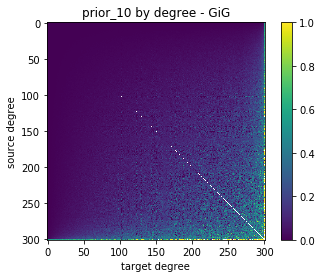

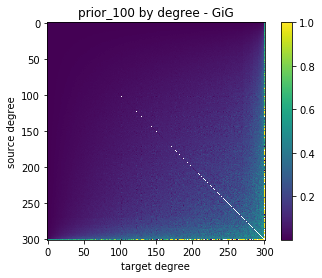

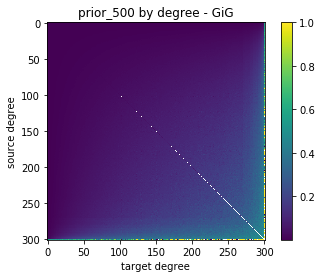

In [8]:
heatmaps = {
    feature: pd.crosstab(counter_df['source_degree'], counter_df['target_degree'],
                         counter_df[feature], aggfunc=sum)
    for feature in ['prior_10', 'prior_100', 'prior_500']
}

for feature_name, df in heatmaps.items():
    fig, ax = plt.subplots()
    heatmap = ax.imshow(df.values)
    plt.colorbar(heatmap)
    plt.title(f'{feature_name} by degree - GiG')
    plt.xlabel('target degree')
    plt.ylabel('source degree')